## ISMRM 2021 Software Demo: 
## Nonlinear Model-based Reconstruction for Quantitative MRI with BART

This tutorial uses the BART command-line inteface (CLI) and presents how to perform nonlinear model-based reconstruction for quantitative MRI (T1 mapping, water/fat separation) using [BART](http://mrirecon.github.io/bart/).

**Main Reference**

    Wang X, Tan Z, Scholand N, Roeloffs V, Uecker M. [Physics-based Reconstruction Methods for Magnetic Resonance Imaging](https://arxiv.org/abs/2010.01403) Philos Trans R Soc A 2021;379:20200196.

**Authors**: [Xiaoqing Wang](mailto:xiaoqing.wang@med.uni-goettingen.de), [Zhengguo Tan](mailto:zhengguo.tan@med.uni-goettingen.de), [Nick Scholand](mailto:nick.scholand@med.uni-goettingen.de), [Christian Holme](mailto:christian.holme@med.uni-goettingen.de)

**Institution**: University Medical Center Göttingen

### 0. Setup BART

#### 0.1 Google colab
The cell will setup BART on Google Colab. For a detailed explanation, see **How to Run BART on Google Colaboratory** in the same [repository](https://github.com/mrirecon/bart-workshop/tree/master/ismrm2021). You can skip this part if you want to run this notebook on your local machine.

This tutorial do need a GPU, you can select one by going to **Edit → Notebook settings**: Choose **GPU** from **Hardware accelerator** drop-down menu.

In [ ]:
%%bash

# Use CUDA 10.1 when on Tesla K80

# Estimate GPU Type
GPU_NAME=$(nvidia-smi --query-gpu=gpu_name --format=csv,noheader)

echo "GPU Type:"
echo $GPU_NAME

if [ "Tesla K80" = "$GPU_NAME" ];
then
    echo "GPU type Tesla K80 does not support CUDA 11. Set CUDA to version 10.1."

    # Change default CUDA to version 10.1
    cd /usr/local
    rm cuda
    ln -s cuda-10.1 cuda
else
    echo "Current GPU supports default CUDA-11."
    echo "No further actions are necessary."
fi

echo "GPU Information:"
nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv
nvcc --version

GPU Type:
Tesla T4
Current GPU supports default CUDA-11.
No further actions are necessary.
GPU Information:
name, driver_version, memory.total [MiB]
Tesla T4, 460.32.03, 15109 MiB
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0


In [ ]:
 %%bash

# Install BARTs dependencies
apt-get install -y make gcc libfftw3-dev liblapacke-dev libpng-dev libopenblas-dev &> /dev/null

# Clone Bart
[ -d /content/bart ] && rm -r /content/bart
git clone https://github.com/mrirecon/bart/ bart &> /dev/null

In [ ]:
%%bash

BRANCH=master

cd bart

# Switch to desired branch of the BART project
git checkout $BRANCH

# Define specifications 
COMPILE_SPECS=" PARALLEL=1
                CUDA=1
                CUDA_BASE=/usr/local/cuda
                CUDA_LIB=lib64
                OPENBLAS=1
                BLAS_THREADSAFE=1"

printf "%s\n" $COMPILE_SPECS > Makefiles/Makefile.local

make &> /dev/null

Your branch is up to date with 'origin/master'.


Already on 'master'


In [ ]:
import os
import sys

# Define environment variables for BART and OpenMP

os.environ['TOOLBOX_PATH'] = "/content/bart"

os.environ['OMP_NUM_THREADS']="4"

# Add the BARTs toolbox to the PATH variable

os.environ['PATH'] = os.environ['TOOLBOX_PATH'] + ":" + os.environ['PATH']
sys.path.append(os.environ['TOOLBOX_PATH'] + "/python")
from IPython.display import Image

#### (0.2 Local machine) - OPTIONAL!

**For** the **presentation** of this tutorial, I will run this notebook on my local machine. I have BART already installed and will define the required environmental variables.

In [ ]:
import os

os.environ["TOOLBOX_PATH"] = "/home/xwang/bart"
os.environ["PATH"] = os.getenv("TOOLBOX_PATH") + os.pathsep + os.getenv("PATH")

#### 0.3 Check BART version

Let us check the installes BART version.

In [ ]:
%% bash
echo "# The BART used in this notebook:"
which bart
echo "# BART version: "
bart version

<a id='download-materials'></a>
### Download Supporting Materials

For this tutorial we need some supporting materials for plotting and precomputed data. To run comfortable on Google Colab, we stored them in our GitHub repository and download them from there.

In [2]:
%%bash

# Download supporting materials for this notebook
if [ ! -f bart_moba.zip ]; then
    wget https://github.com/mrirecon/bart-workshop/raw/master/ismrm2021/model_based/bart_moba.zip
fi

unzip -n bart_moba.zip

Archive:  bart_moba.zip
  inflating: ME-FLASH-5-cc.cfl       
  inflating: ME-FLASH-5-cc.hdr       
  inflating: toimg_water_fat_B0.py   


# Part I. Model-based Reconstruction for IR-FLASH

## 1. Introduction
### 1.1 Single-Shot Inversion-Prepared T1 Mapping

<img src="https://github.com/mrirecon/bart-workshop/blob/master/ismrm2021/model_based/IR_FLASH.png?raw=1" style="width: 550px;">

**General Idea of Model-based Reconstruction**:

    Formulating the estimation of MR physical parameters directly from k-space as a nonlinear inverse problem

### 1.2 Operator chain of parallel imaging and signal model (nonlinear)

<img src="https://github.com/mrirecon/bart-workshop/blob/master/ismrm2021/model_based/operator_chain.png?raw=1" style="width: 400px;">

$$F: x \mapsto y = {\mathcal{P} \mathcal{F} C} \cdot {M(x_{p})}$$
- $\mathcal{P}$ - sampling pattern
- $\mathcal{F}$ - Fourier transform
- $C$ - coil sensitivity maps
- $M(\cdot)$ - MR physics model
- $x_{p}$ - MR parameters
- $y$ - acquired kspace data

### 1.3 Optimization

We use the iteratively regularized Gauss-Newton method (IRGNM) in BART to solve the nonlinear inverse problem

$$\hat{x} = \text{argmin}_{x}\|F(x) -y\|_{2}^{2} + \lambda \cdot R(x), $$

i.e., the nonlinear problem can be linearly solved in each Gauss-Newton step:

$$\hat{x}_{n+1}= \text{argmin}_{x}\|DF(x_{n})(x−x_{n}) +F(x_{n})−y\|_{2}^{2} + \lambda \cdot R(x)$$

$DF(x_{n})$ is the Jacobian matrix of $F$ at the point $x_{n}$ of the $n$th Newton step.

---

Therefore, we can directly estimate the MR parameter maps from undersampled k-space datasets. No pixel-wise fitting on intermediate images is required!

For further information have a look into:

[Wang X](mailto:xiaoqing.wang@med.uni-goettingen.de), Roeloffs V, Klosowski J, Tan Z, Voit D, Uecker M, Frahm J.,  
[Model-based T1 Mapping with Sparsity Constraints Using Single-Shot Inversion-Recovery Radial FLASH](https://onlinelibrary.wiley.com/doi/full/10.1002/mrm.26726).  
Magn Reson Med 2018;79:730-740.

### 1.4 BART Commands

The model-based reconstruction framework in BART can be accessed from the command line by using the `moba` function. Let us hav a look into its options. It now supports not only T1, but also T2 and T2* models.

In [3]:
%%bash

#### moba now supports T1, T2, water-fat and T2* mapping
bart moba -h

Usage: moba [-r ...] [-L ...] [-F ...] [-G ...] [-m d] [-l d] [-i d] [-R f] [-T f] [-j f] [-u f] [-C d] [-s f] [-B f] [-b ...] [-d d] [-f f] [-p <string>] [-J] [-M] [-g] [-I <string>] [-t <string>] [-o f] [-k] [--kfilter-1 ...] [--kfilter-2 ...] [-n] [--fat_spec_0 ...] <kspace> <TI/TE> <output> [<sensitivities>]

Model-based nonlinear inverse reconstruction


-r <T>:A:B:C	generalized regularization options (-rh for help)
-L		T1 mapping using model-based look-locker
-F		T2 mapping using model-based Fast Spin Echo
-G		T2* mapping using model-based multiple gradient echo
-m model      	Select the MGRE model from enum { WF = 0, WFR2S, WF2R2S, R2S, PHASEDIFF } [default: WFR2S]
-l reg      	1/-l2	toggle l1-wavelet or l2 regularization.
-i iter      	Number of Newton steps
-R redu      	reduction factor
-T damp      	damping on temporal frames
-j minreg      	Minimum regu. parameter
-u rho      	ADMM rho [default: 0.01]
-C iter      	inner iterations
-s step      	step size
-B bound      	low

## 2. Data Preparation 

The data preparation is dicussed in detail in the [3rd event of the BART webinar series](https://github.com/mrirecon/bart-webinars/tree/master/webinar3). Here you can find presentation and exercise materials for the individual steps

2.1 Download raw data  
2.2 Coil compression  
2.3 Prepare radial trajectory (golden-angle) including gradient-delay correction  
2.4 Prepare time vector

which should not be mentioned in detail here.

#### 2.1 Download Raw Data

In [ ]:
%%bash

## Download raw data
if [ ! -f IR-FLASH.cfl ]; then
  wget -q https://zenodo.org/record/4060287/files/IR-FLASH.cfl
  wget -q https://zenodo.org/record/4060287/files/IR-FLASH.hdr
fi

head -n2 IR-FLASH.hdr

# Dimensions
512 1 1 16 1 1 1 1 1 1 1020 1 1 1 1 1 


#### 2.2 Coil Compression

In [ ]:
%%bash

## Coil compression
bart transpose 0 1 IR-FLASH ksp

# number of virtual coils
NUM_VCOILS=3 # for the purpose of fast computation, for better performance, 8 or 10 is recommended.
# coil compression
bart cc -A -p $NUM_VCOILS ksp ksp_cc

Done.


#### 2.3 Trajectory Preparation with Gradient Delay Correction

In [ ]:
%%bash

# Assign dimensions to variables
READ=`bart show -d 0 IR-FLASH`
SPOKES=`bart show -d 2 IR-FLASH`
COILS=`bart show -d 3 IR-FLASH`
TIME=`bart show -d 10 IR-FLASH`
BR=$((READ/2))

## Prepare radial trajectory (golden-angle)
bart traj -r -c -D -G -x$READ -y$SPOKES -s7 -t$TIME traj

# Gradient Delay Correction
# Extract the steady-state data (data with less contrast change)
bart extract 10 920 1020 traj traj_extract
bart extract 10 920 1020 ksp_cc ksp_extract

# Transpose the 2nd and 10th dimension for the `estdelay` tool
bart transpose 10 2 traj_extract traj_extract1
bart transpose 10 2 ksp_extract ksp_extract1

# Gradient delay estimation usign RING
GDELAY=$(bart estdelay -R traj_extract1 ksp_extract1)

echo "Gradient Delays: "$GDELAY

# Calculate the "correct" trajectory with known gradient delays
bart traj -r -c -D -G -x$READ -y$SPOKES -s7 -t$TIME -q $GDELAY trajn

Gradient Delays: -0.120477:0.166771:0.008643


#### 2.4 Preparation of Time Vector

In [ ]:
%%bash

## Prepare time vector
TR=4100 #TR in [us]
BIN_SPOKES=20 # Bin data to save computational time 
TIME=`bart show -d 10 IR-FLASH`
NTIME=$((TIME/BIN_SPOKES))

# Create vector from 0 to NTIME
bart index 5 $NTIME tmp1
# use local index from newer bart with older bart
bart scale $(($BIN_SPOKES * $TR)) tmp1 tmp2
bart ones 6 1 1 1 1 1 $NTIME tmp1 
bart saxpy $((($BIN_SPOKES / 2) * $TR)) tmp1 tmp2 tmp3
bart scale 0.000001 tmp3 TI

# Reshape trajectory and data for model-based reconstruction
bart reshape $(bart bitmask 2 5 10) $BIN_SPOKES $NTIME 1 trajn traj_moba
bart reshape $(bart bitmask 2 5 10) $BIN_SPOKES $NTIME 1 ksp_cc ksp_cc_moba

# Resize data and trajectory for faster computation
bart resize -c 1 384 traj_moba traj_moba1
bart resize -c 1 384 ksp_cc_moba ksp_cc_moba1

echo "Trajectory:"
head -n2 traj_moba1.hdr

echo "Data:"
head -n2 ksp_cc_moba1.hdr

echo "TI:"
head -n2 TI.hdr''

Trajectory:
# Dimensions
3 384 20 1 1 51 1 1 1 1 1 1 1 1 1 1 
Data:
# Dimensions
1 384 20 3 1 51 1 1 1 1 1 1 1 1 1 1 
TI:
# Dimensions
1 1 1 1 1 51 1 1 1 1 1 1 1 1 1 1 


### 3. Nonlinear Model-based Reconstruction
3.1 Model-based reconstruction

In [ ]:
# inversion-recovery Look-Locker T1 mapping

!bart moba -L -g -d4 -l1 -i8 -C100 -j0.09 -B0.0 -n -t traj_moba1 ksp_cc_moba1 TI reco_moba 

#-L  --- to select look-locker model
#-g  --- to use GPU
#-d  --- debug level
#-l1 --- to use l1-Wavelet regularization
#-i  --- number of Newton-steps
#-C  --- maximum number of inner iterations (FISTA)
#-j  --- minimum regularization parameter
#-B  --- lower bound for relaxivity (R1s > 0)

# Note: There is no need of input of coil sensitivity maps, because we jointly estimate coils using model-based reconstruction

nufft kernel dims: [  1 384  20   1   1  51   1   1   1   1   1   1   1   1   1   1   1 ]
nufft psf dims:    [480 480   1   1   1  51   1   1   1   1   1   1   1   1   1   1   1 ]
nufft traj dims:   [  3 384  20   1   1  51   1   1   1   1   1   1   1   1   1   1   1 ]
Allocating 391680 (vs. 12142080) + 11750400
ksp : [  1 384  20   1   1  51   1   1   1   1   1   1   1   1   1   1   1 ]
cim : [480 480   1   1   1  51   1   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3 384  20   1   1  51   1   1   1   1   1   1   1   1   1   1   1 ]
ksp : [  1 384  20   3   1  51   1   1   1   1   1   1   1   1   1   1 ]
cim : [480 480   1   3   1  51   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3 384  20   1   1  51   1   1   1   1   1   1   1   1   1   1 ]
tcmalloc: large alloc 1128038400 bytes == 0x56015b906000 @  0x7f992105b1e7 0x56013cc1f389 0x56013cb6b2f2 0x56013cb7804e 0x56013cb78c7d 0x56013cb46aef 0x56013cb1f5c8 0x56013cb1f51f 0x7f990ee4ebf7 0x56013cb1f2ea
Scaling: 15409.008528
Scal

3.2 Visualize results

Writing 1 image(s)...done.


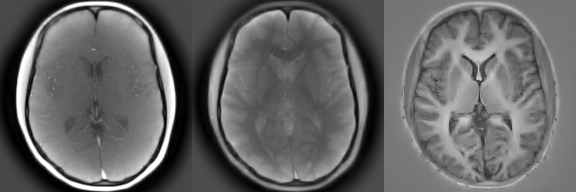

In [ ]:
## Resize and Display the reconstructed maps, i.e., (Mss. M0, R1*)
!bart resize -c 0 192 1 192 reco_moba reco_maps
!bart resize -c 0 192 1 192 reco_moba reco_maps
!bart slice 6 0 reco_maps Mss
!bart slice 6 1 reco_maps M0
!bart slice 6 2 reco_maps R1s

!bart join 1 Mss M0 R1s tmp
!bart flip $(bart bitmask 0) tmp maps_all

!bart toimg -W maps_all maps_all.png
Image("maps_all.png", width=1000)

Finally, from the above parameters, we can calculate and visualize the estimated T1 map.

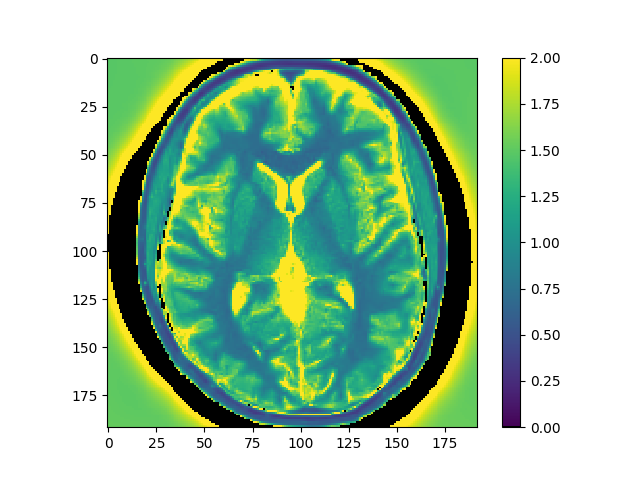

In [ ]:
## use the "looklocker" tool in BART for post-processing
!bart looklocker -t0.2 -D15.3e-3 reco_maps tmp
!bart flip $(bart bitmask 0) tmp moba_T1map
!python3 save_maps.py moba_T1map viridis 0 2.0 moba_T1map.png
Image("moba_T1map.png", width=600)

Thank you for joining! Feel free to ask any questions:)

# Part II. Model-based Reconstruction on Multi-Echo Radial FLASH



This part of the notebook describes and demonstrates how to perform three-point water/fat separation and $B_0$ field mapping from multi-gradient-echo radial FLASH data. 

----
**For more information, please refer to this paper:**

[Tan Z](mailto:zhengguo.tan@med.uni-goettingen.de), Voit D, Kollmeier JM, Uecker M, Frahm J. [Dynamic water/fat separation and inhomogeneity mapping — joint estimation using undersampled triple‐echo multi‐spoke radial FLASH](https://doi.org/10.1002/mrm.27795). Magn Reson Med 2019;82:1000-1011.

----
**The data used in this tutorial is from this paper:**

Wang X, Tan Z, Scholand N, Roeloffs V, Uecker M. [Physics-based reconstruction methods for MRI](https://arxiv.org/abs/2010.01403). Philos Trans R Soc A 2021;379:20200196.

----

### 1. Multi-Echo Radial FLASH Sequence and *k*-Space Trajectory

![](https://github.com/mrirecon/bart-workshop/blob/master/ismrm2021/model_based/ME_FLASH.png?raw=1)
> Multiple gradient echoes are acquired after each RF excitation. 
> Every echo samples different *k*-space radial spoke with the use of triangular blip gradients.

### 2. Signal Modeling In the Case of Three-Echo Acquisition

The $m$th echo image ($\rho_m$) acquired at echo time TE$_m$ follows

$\rho_m = \big( \text{W} + \text{F} \cdot z_m \big) \cdot e^{i 2\pi f_{B_0} \text{TE}_m}$, 

with $\text{W}$ and $\text{F}$ being the water and fat images, and $f_{B_0}$ the $B_0$ field inhomogeneity map. The fat chemical shift phase modulation $z_m = \sum_{p=1}^6 \alpha_p e^{i2\pi f_p \text{TE}_m}$.

As shown previously in the software session, this signal model (implemented as a nonlinear operator in BART) can be chained with the parallel imaging model, and the complete unknown $x = (\text{W}, \text{F}, f_{B_0}, c_1, \cdots, c_N)^T$, where $c_j$ represents the coil sensitivity map.

### Step 1. Get the Raw Data
We downloaded all supporting materials already in the [previous section](#download-materials).  
Let us check the dimensions of our raw data:

In [3]:
%%bash

head -n2 ME-FLASH-5-cc.hdr

# Dimensions
400 231 1 6 1 1 1 1 1 1 5 1 1 1 1 1 


### Step 2. Prepare Raw Data for Image Reconstruction in BART

- Reorder *k*-space data; 
- Compute trajectory;
- Create echo time (TE) file.

In [ ]:
%%bash

# --- dimensions ---

ECHOES=7

SAMPLES=$(bart show -d 0 ME-FLASH-5-cc)

TOT_SPOKES=$(bart show -d 1 ME-FLASH-5-cc)
SPOKES=$(( TOT_SPOKES / ECHOES ))

COILS=$(bart show -d 3 ME-FLASH-5-cc)
FRAMES=$(bart show -d 10 ME-FLASH-5-cc)


# --- k-space data ---

bart reshape $(bart bitmask 0 1 2) 1 ${SAMPLES} ${TOT_SPOKES} ME-FLASH-5-cc temp_kdat0

bart reshape $(bart bitmask 2 5) ${ECHOES} ${SPOKES} temp_kdat0 temp_kdat1

bart transpose 2 5 temp_kdat1 kdat_reorder

rm temp_kdat{0,1}.{hdr,cfl}

echo "# k-space data: "
head -n2 kdat_reorder.hdr
echo ""


# --- trajectory ---

bart traj -x ${SAMPLES} -y ${SPOKES} -t ${FRAMES} -r -s 2 -D -E -e ${ECHOES} -c traj

echo "# trajectory: "
head -n2 traj.hdr
echo ""

# --- TE ---

bart index 5 ${ECHOES} temp_incre

bart ones 6 1 1 1 1 1 ${ECHOES} temp_one

bart scale 1.37 temp_one temp_TE1

bart saxpy 1.34 temp_incre temp_TE1 TE

rm temp_{incre,one,TE1}.{hdr,cfl}

echo "# TE: "
bart show TE


# --- use the first three echoes ---
# --- use only seven frames for demonstration purpose ---

bart extract 5 0 3 kdat_reorder kdat_3eco
bart extract 5 0 3 traj traj_3eco
bart extract 5 0 3 TE TE_part

SPOKES=$(bart show -d  2 kdat_3eco)
FRAMES=$(bart show -d 10 kdat_3eco)

bart reshape $(bart bitmask 2 10) $((SPOKES * FRAMES)) 1 kdat_3eco kdat_part
bart reshape $(bart bitmask 2 10) $((SPOKES * FRAMES)) 1 traj_3eco traj_part

# k-space data: 
# Dimensions
1 400 33 6 1 7 1 1 1 1 5 1 1 1 1 1 

# trajectory: 
# Dimensions
3 400 33 1 1 7 1 1 1 1 5 1 1 1 1 1 

# TE: 
+1.370000e+00+0.000000e+00i	+2.710000e+00+0.000000e+00i	+4.050000e+00+0.000000e+00i	+5.390000e+00+0.000000e+00i	+6.730000e+00+0.000000e+00i	+8.070001e+00+0.000000e+00i	+9.410000e+00+0.000000e+00i


**Water/fat separation and $B_0$ field mapping via model-based reconstruction**

In [ ]:
# --- moba ---

# bart moba 
# -G -m0 --> multi-gradient-echo model as listed above
# -b88:1 --> spatial smoothness constraint on B0 map 
# -i8 -R2 --> number of iterations and reduction factor
# -o1.2 --> overgrid factor
# -g --> use gpu
# -t traj_part kdat_part TE_part R_M0_2 C_M0_2

! bart moba -G -m 0 -b 88:1 -i 8 -R 2 -o 1.2 -g -d 4 -t traj_part kdat_part TE_part R_M0_2 C_M0_2

! bart resize -c 0 200 1 200 R_M0_2 R_WF
! bart resize -c 0 200 1 200 C_M0_2 C_WF

nufft kernel dims: [  1 400 165   1   1   3   1   1   1   1   1   1   1   1   1   1   1 ]
nufft psf dims:    [480 480   1   1   1   3   1   1   1   1   1   1   1   1   1   1   1 ]
nufft traj dims:   [  3 400 165   1   1   3   1   1   1   1   1   1   1   1   1   1   1 ]
Allocating 198000 (vs. 889200) + 691200
ksp : [  1 400 165   1   1   3   1   1   1   1   1   1   1   1   1   1   1 ]
cim : [480 480   1   1   1   3   1   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3 400 165   1   1   3   1   1   1   1   1   1   1   1   1   1   1 ]
ksp : [  1 400 165   6   1   3   1   1   1   1   1   1   1   1   1   1 ]
cim : [480 480   1   6   1   3   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3 400 165   1   1   3   1   1   1   1   1   1   1   1   1   1 ]
>>> frame   0
 sobolev weight on fB0
 >> linearized problem solved by CG
Step: 0, Res: 99.999995
	 cg:   2
Step: 1, Res: 82.962217
	 cg:   2
Step: 2, Res: 72.169705
	 cg:   5
Step: 3, Res: 54.492353
	 cg:  10
Step: 4, Res: 46.703269
	 cg:  

**2.4 Visualization**

- **Display model-based reconstructed $\text{W}$, $\text{F}$ and $f_{B_0}$ maps**

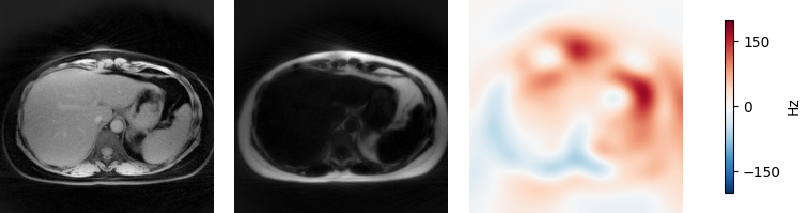

In [ ]:
! bart flip $(bart bitmask 0) R_WF R_WF_flip

! python3 toimg_water_fat_B0.py R_WF_flip R_WF.png

from IPython.display import Image
Image(filename='R_WF.png')


* **Display model-based reconstructed coil sensitivity maps**

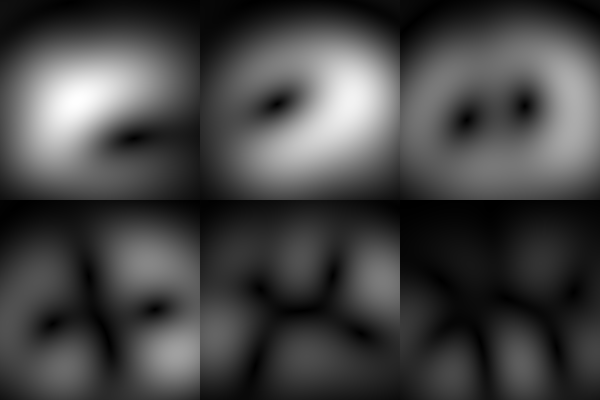

In [ ]:
! bart flip $(bart bitmask 0) C_WF C_WF_flip

! bart reshape $(bart bitmask 3 4) 3 2 C_WF_flip C_WF_flip_3x2

! bart reshape $(bart bitmask 1 3) 600 1 C_WF_flip_3x2 C_WF_flip_1x2
! bart reshape $(bart bitmask 0 4) 400 1 C_WF_flip_1x2 C_WF_flip_comb

! bart toimg C_WF_flip_comb C_WF > /dev/null

from IPython.display import Image
Image(filename='C_WF.png')